In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import joblib


ModuleNotFoundError: No module named 'xgboost'

In [ ]:

df_full = pd.read_csv("PS_20174392719_1491204439457_log.csv")
df_full = df_full.drop(columns=["isFlaggedFraud", "nameOrig", "nameDest"])

fraud = df_full[df_full.isFraud == 1].sample(n=min(50, len(df_full[df_full.isFraud == 1])), random_state=42)
nonf = df_full[df_full.isFraud == 0].sample(n=3000 - len(fraud), random_state=42)

df = pd.concat([fraud, nonf]).sample(frac=1, random_state=123).reset_index(drop=True)

print("shape:", df.shape, "| fraud count:", int(df.isFraud.sum()))
display(df.head(10))

class_balance = df.isFraud.value_counts().sort_index().rename_axis('isFraud').reset_index(name='Count')
display(class_balance)


shape: (3000, 8) | fraud count: 50


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,310,PAYMENT,6939.98,0.00,0.00,0.00,0.00,0
1,347,CASH_IN,113362.94,24587.00,137949.94,3247086.97,3187523.77,0
2,250,CASH_IN,407359.73,1692102.35,2099462.08,1529631.96,1122272.22,0
3,153,CASH_OUT,203911.81,0.00,0.00,410894.10,614805.92,0
4,278,CASH_OUT,287571.79,29878.00,0.00,385445.52,673017.31,0
5,545,PAYMENT,2927.48,0.00,0.00,0.00,0.00,0
6,163,CASH_OUT,711438.39,0.00,0.00,6991993.36,7703431.75,0
7,160,CASH_OUT,200330.14,387.00,0.00,3079166.74,3321302.80,0
8,185,CASH_OUT,20665.94,0.00,0.00,1010257.27,1030923.22,0
9,211,PAYMENT,11767.19,336245.12,324477.93,0.00,0.00,0


,isFraud,Count
0,0,2950
1,1,50


In [ ]:
# 3a. Check for missing values
print(df.isnull().sum())

# 3b. Drop missing values if any
df = df.dropna()

# 3c. Encode categorical variables
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# 3d. Scale features
feature_cols = [col for col in df.columns if col not in ['isFraud', 'nameOrig', 'nameDest']]
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])


step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64


In [ ]:
X = df[feature_cols]
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced', max_iter=1000)
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [8, 16]}


In [ ]:
from xgboost import XGBClassifier

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, tree_method='hist',
                    use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [6, 12]}


In [ ]:
def grid_search(model, param_grid):
    gs = GridSearchCV(model, param_grid, scoring='average_precision', cv=3,
                      verbose=2, n_jobs=-1)
    gs.fit(X_train, y_train)
    print(f"Best score: {gs.best_score_}")
    print(f"Best params: {gs.best_params_}")
    return gs


In [ ]:
print("Tuning Logistic Regression...")
gs_lr = grid_search(lr, param_grid_lr)

print("Tuning Random Forest...")
gs_rf = grid_search(rf, param_grid_rf)

print("Tuning XGBoost...")
gs_xgb = grid_search(xgb, param_grid_xgb)


Tuning Logistic Regression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best score: 0.6844387101075312
Best params: {'C': 10}
Tuning Random Forest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best score: 0.9038336555744358
Best params: {'max_depth': 16, 'n_estimators': 200}
Tuning XGBoost...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best score: 0.8541573772327125
Best params: {'max_depth': 12, 'n_estimators': 100}


C:\Users\User\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:37:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


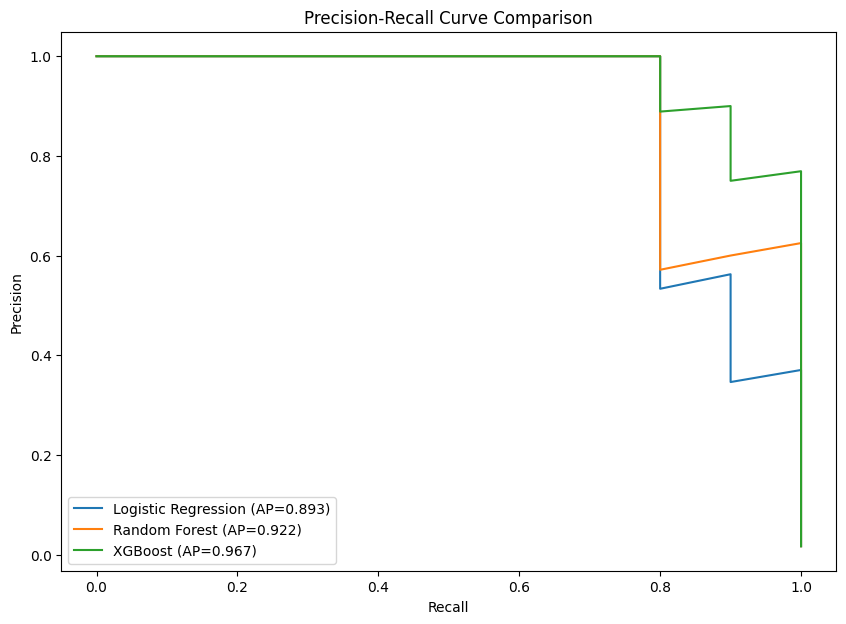

In [ ]:
def plot_pr_curve(model, X_test, y_test, label):
    y_scores = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    plt.plot(recall, precision, label=f'{label} (AP={ap:.3f})')
    return ap

plt.figure(figsize=(10, 7))
ap_lr = plot_pr_curve(gs_lr.best_estimator_, X_test, y_test, "Logistic Regression")
ap_rf = plot_pr_curve(gs_rf.best_estimator_, X_test, y_test, "Random Forest")
ap_xgb = plot_pr_curve(gs_xgb.best_estimator_, X_test, y_test, "XGBoost")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()


In [ ]:
# Assuming XGBoost has the best average precision score
best_model = gs_xgb.best_estimator_
joblib.dump(best_model, 'best_fraud_detection_model.pkl')
print("Best model saved as 'best_fraud_detection_model.pkl'")


Best model saved as 'best_fraud_detection_model.pkl'
